In [1]:
import time
import yaml
import joblib

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

## Load Dataset

In [2]:
df_train = pd.read_parquet("../dataset/combined/train-sel-10.parquet")
df_test = pd.read_parquet("../dataset/combined/test-sel-10.parquet")

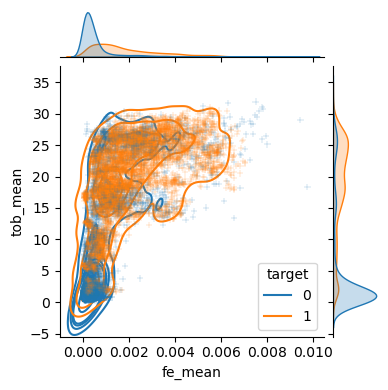

In [91]:
g = sns.jointplot(df_test, x="fe_mean", y="tob_mean", hue="target", kind="scatter", marker="+", s=20, alpha=0.4, height=4)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

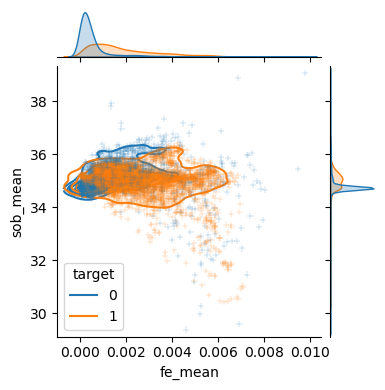

In [90]:
g = sns.jointplot(df_test, x="fe_mean", y="sob_mean", hue="target", kind="scatter", marker="+", s=20, alpha=0.4, height=4)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)

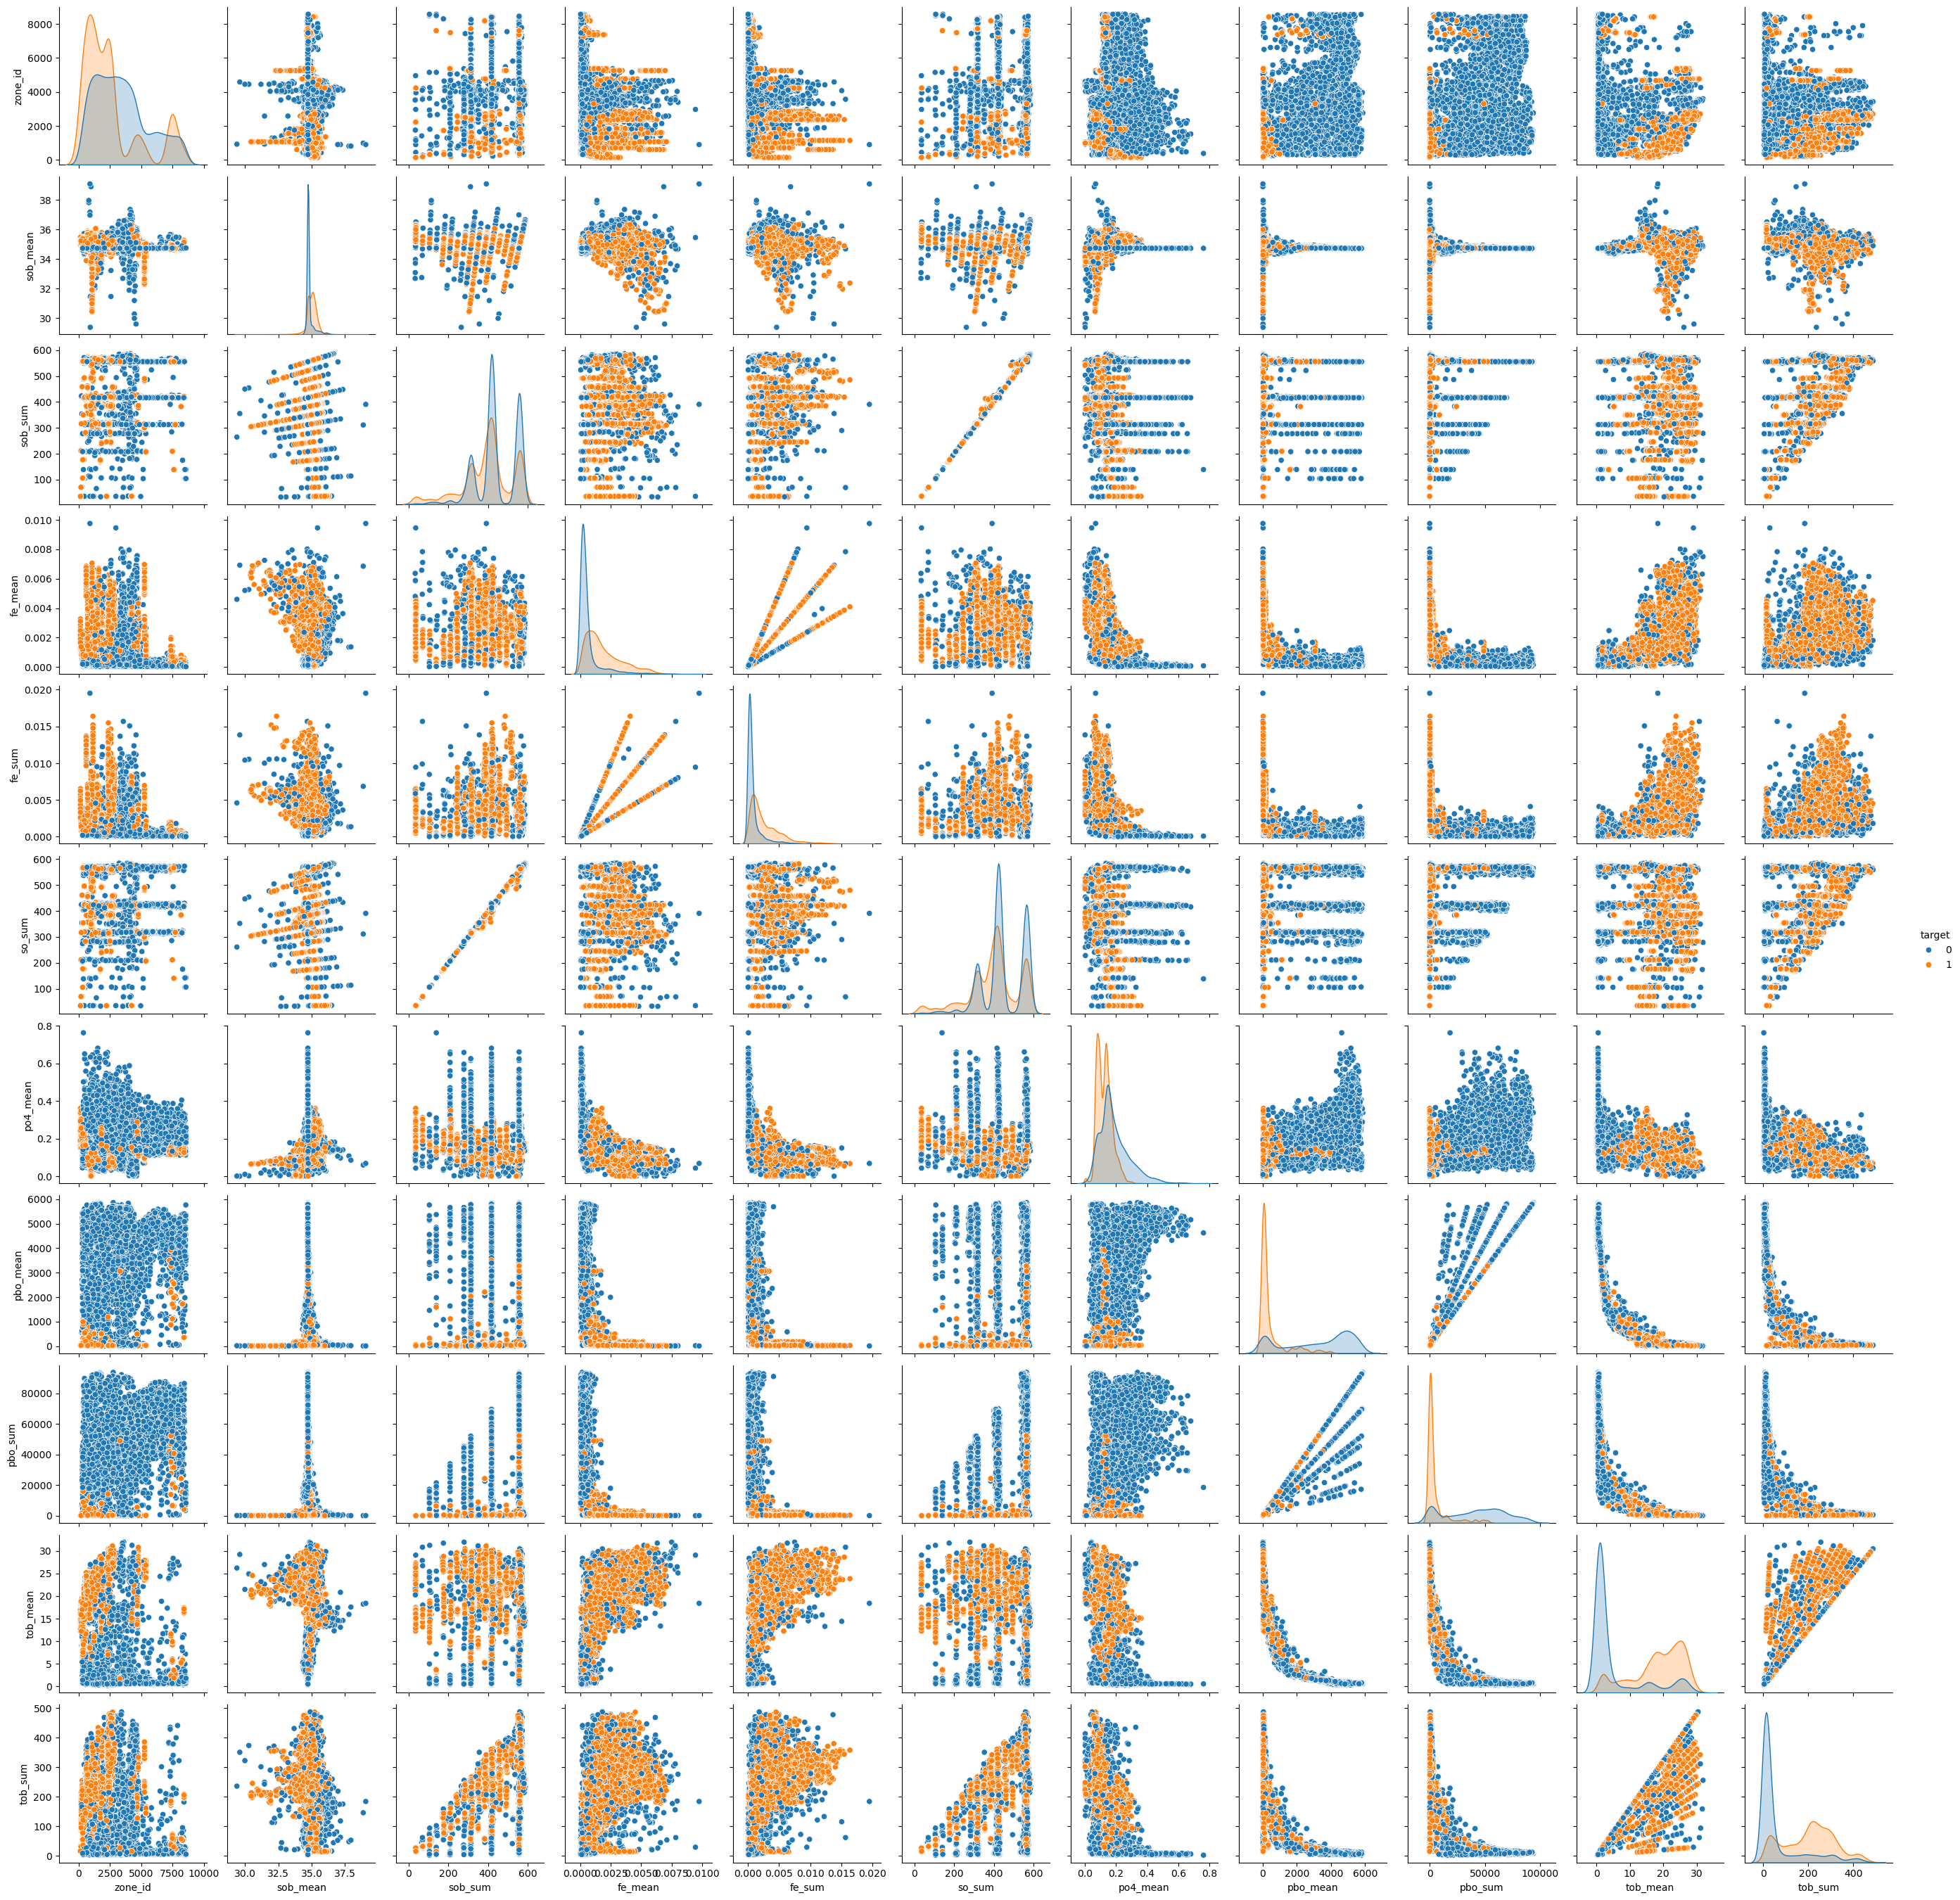

In [73]:
sns.pairplot(df_test, hue="target")

In [3]:
X_train, y_train = df_train.drop(columns=["zone_id", "target"]), df_train["target"]
X_test, y_test = df_test.drop(columns=["zone_id", "target"]), df_test["target"]

In [4]:
scaler = MinMaxScaler()
X_train_t = scaler.fit_transform(X_train)
X_test_t = scaler.transform(X_test)

In [5]:
train_pool = Pool(X_train_t, y_train, feature_names=X_train.columns.tolist())
test_pool = Pool(X_test_t, y_test, feature_names=X_test.columns.tolist())

## Train

In [6]:
# best_params = yaml.safe_load(open("../dataset/models/best_params_decision_tree.yml", "r"))
# clf = DecisionTreeClassifier(**best_params)

# best_params = yaml.safe_load(open("../dataset/models/best_params_random_forest.yml", "r"))
# clf = RandomForestClassifier(**best_params)

best_params = yaml.safe_load(open("../dataset/models/best_params_catboost.yml", "r"))
clf = CatBoostClassifier(**best_params)

# best_params = yaml.safe_load(open("../dataset/models/best_params_xgboost.yml", "r"))
# clf = XGBClassifier(**best_params)

st = time.time()
clf.fit(X_train_t, y_train)
dt = time.time() - st

# joblib.dump(clf, "../dataset/models/random_forest.joblib")
# clf.save_model("../dataset/models/catboost.cbm")
# clf.save_model("../dataset/models/xgboost.json")
print("Time:", np.round(dt, 4))

0:	learn: 0.6474874	total: 134ms	remaining: 3m 54s
1:	learn: 0.6039093	total: 201ms	remaining: 2m 56s
2:	learn: 0.5688776	total: 249ms	remaining: 2m 26s
3:	learn: 0.5338911	total: 311ms	remaining: 2m 16s
4:	learn: 0.5006171	total: 394ms	remaining: 2m 18s
5:	learn: 0.4725705	total: 469ms	remaining: 2m 17s
6:	learn: 0.4460810	total: 535ms	remaining: 2m 14s
7:	learn: 0.4194538	total: 624ms	remaining: 2m 16s
8:	learn: 0.3961449	total: 717ms	remaining: 2m 19s
9:	learn: 0.3743321	total: 792ms	remaining: 2m 18s
10:	learn: 0.3553813	total: 869ms	remaining: 2m 18s
11:	learn: 0.3371763	total: 940ms	remaining: 2m 16s
12:	learn: 0.3204050	total: 1.01s	remaining: 2m 16s
13:	learn: 0.3050807	total: 1.08s	remaining: 2m 14s
14:	learn: 0.2922579	total: 1.15s	remaining: 2m 13s
15:	learn: 0.2801837	total: 1.21s	remaining: 2m 12s
16:	learn: 0.2671719	total: 1.29s	remaining: 2m 12s
17:	learn: 0.2556333	total: 1.37s	remaining: 2m 13s
18:	learn: 0.2439782	total: 1.46s	remaining: 2m 14s
19:	learn: 0.2343605	t

## Evaluation

In [7]:
st = time.time()
y_pred = clf.predict(X_test_t)
dt = time.time() - st

print("Time:", np.round(dt, 4))
print("MCC:", np.round(matthews_corrcoef(y_test, y_pred), 4))
print("Accuracy:", np.round(accuracy_score(y_test, y_pred), 4))
print("Precision:", np.round(precision_score(y_test, y_pred), 4))
print("Recall:", np.round(recall_score(y_test, y_pred), 4))
print("F1:", np.round(f1_score(y_test, y_pred), 4))

print(classification_report(y_test, y_pred))

Time: 0.1612
MCC: 0.9939
Accuracy: 0.997
Precision: 0.9942
Recall: 0.9997
F1: 0.997
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6888
           1       0.99      1.00      1.00      6888

    accuracy                           1.00     13776
   macro avg       1.00      1.00      1.00     13776
weighted avg       1.00      1.00      1.00     13776



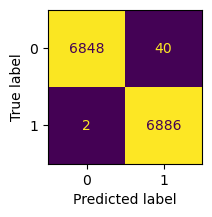

In [8]:
fig, ax = plt.subplots(figsize=(2, 2))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)

## Feature Importance

In [9]:
import shap
shap.initjs()

/home/fahmi/miniforge3/envs/thesis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
df_test[:10]

zone_id   sob_mean     sob_sum   fe_mean    fe_sum      so_sum  \
46424     2842  34.713558  555.416931  0.000033  0.000033  561.625305   
43446     2316  34.749195  416.990356  0.000504  0.000504  411.284454   
44580      632  34.714195  555.427124  0.000302  0.000302  562.422546   
63993     1557  34.754131  417.049561  0.005300  0.005300  416.688568   
41506     3017  34.711544  555.384705  0.000431  0.000431  566.314331   
25726     1810  35.130180  562.082886  0.000211  0.000422  566.969543   
68761     2370  35.181137  422.173645  0.003126  0.012504  422.616394   
57590     2780  34.951298  419.415558  0.003568  0.003568  419.427094   
11401     2428  34.735229  555.763672  0.000031  0.000062  568.503967   
32270     1732  35.259281  387.852081  0.000795  0.000795  384.229919   

       po4_mean     pbo_mean       pbo_sum   tob_mean     tob_sum  target  
46424  0.482038  5373.305176  85972.882812   0.545213    8.723400       0  
43446  0.059090   220.417892   2645.014648  17.517008  210.204102       0  
44580  0.135625  5038.920898  80622.734375   0.702738   11.243803       0  
63993  0.082282    21.253553    255.042633  23.395636  280.747620       1  
41506  0.255083  5293.386230  84694.179688   0.549698    8.795166       0  
25726  0.199428   506.048676   8096.778809  12.591057  201.456909       1  
68761  0.064419    18.225660    218.707932  29.303581  351.642975       1  
57590  0.091109    34.920341    419.044098  25.839842  310.078094       1  
11401  0.211847  2721.955566  43551.289062   1.471048   23.536762       0  
32270  0.187385    97.347023   1070.817261  23.790840  261.699249       1

In [11]:
shap_pool = Pool(X_test_t, y_test, feature_names=X_test.columns.tolist())
shap_df = pd.DataFrame(X_test_t, columns=X_test.columns.tolist())

In [12]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(shap_df)

In [13]:
# Sample 0 - tidak muncul
shap.plots.force(shap_values[0, ...])

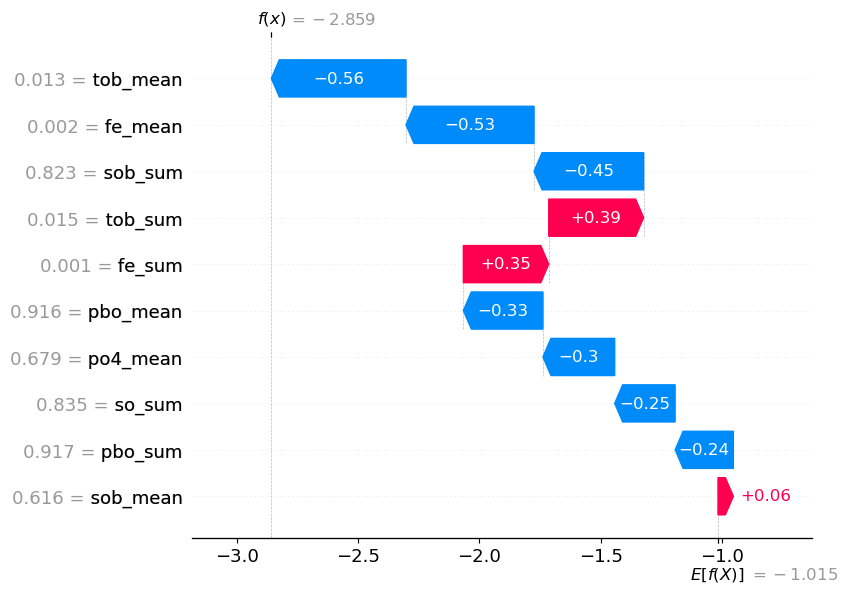

In [14]:
shap.plots.waterfall(shap_values[0])

In [15]:
# Sample 1 - tidak muncul
shap.plots.force(shap_values[1, ...])

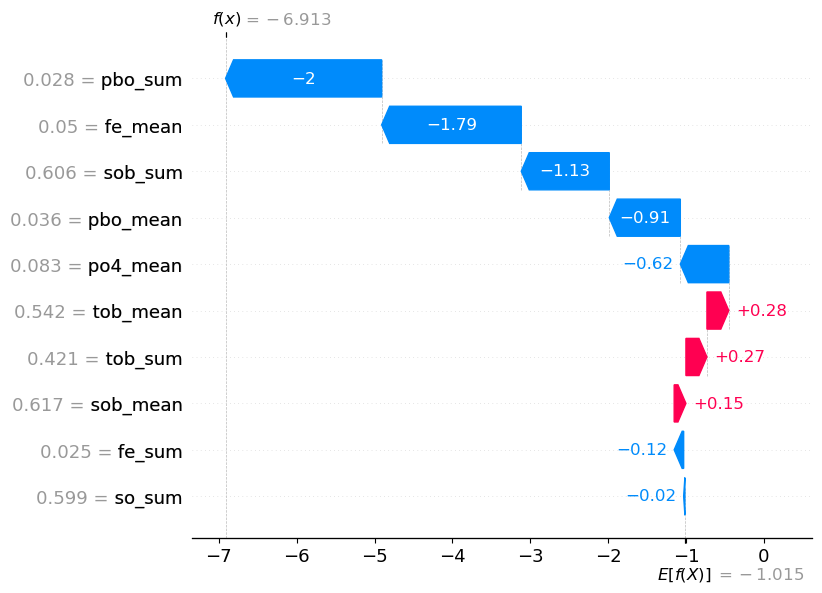

In [16]:
shap.plots.waterfall(shap_values[1])

In [17]:
# Sample 3 - muncul
shap.plots.force(shap_values[3, ...])

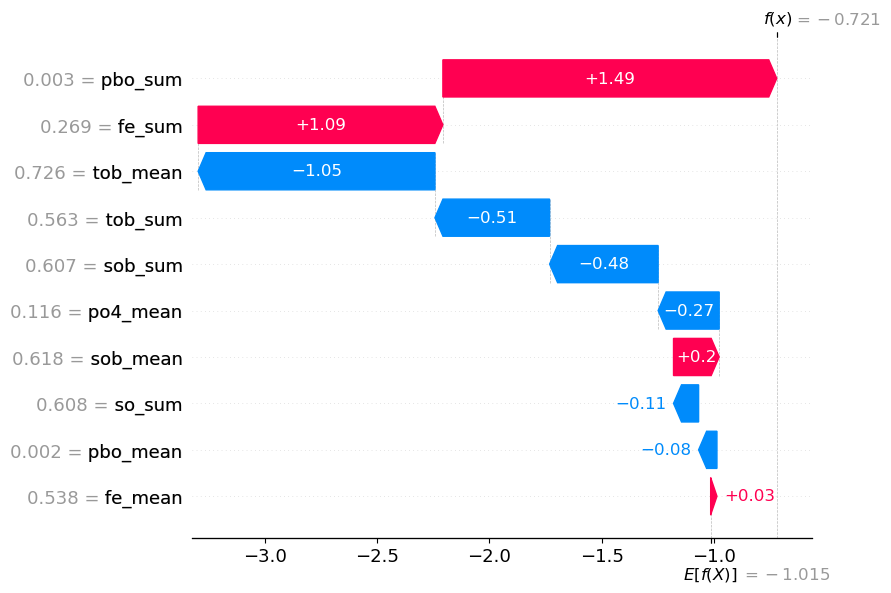

In [18]:
shap.plots.waterfall(shap_values[3])

In [19]:
# Sample 5 - muncul
shap.plots.force(shap_values[5, ...])

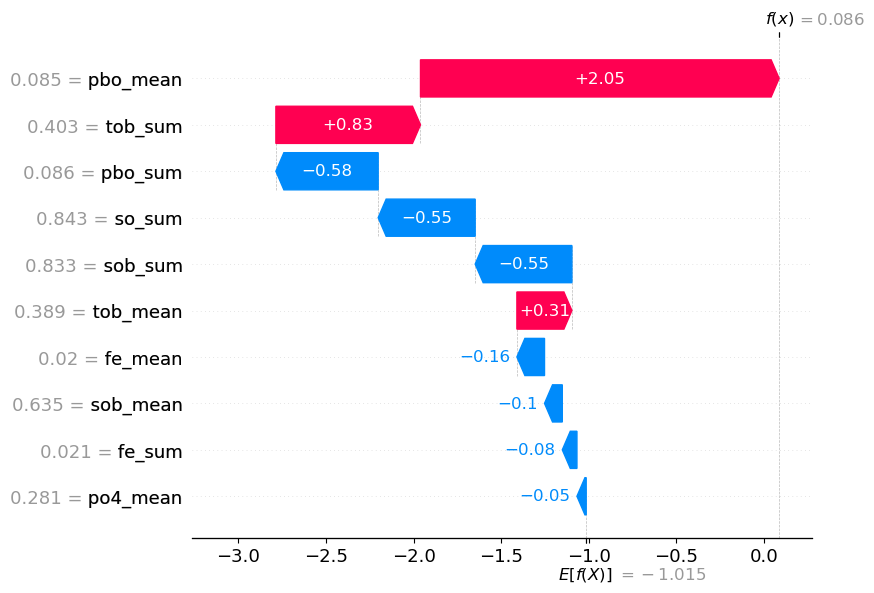

In [20]:
shap.plots.waterfall(shap_values[5])

### Global Importance

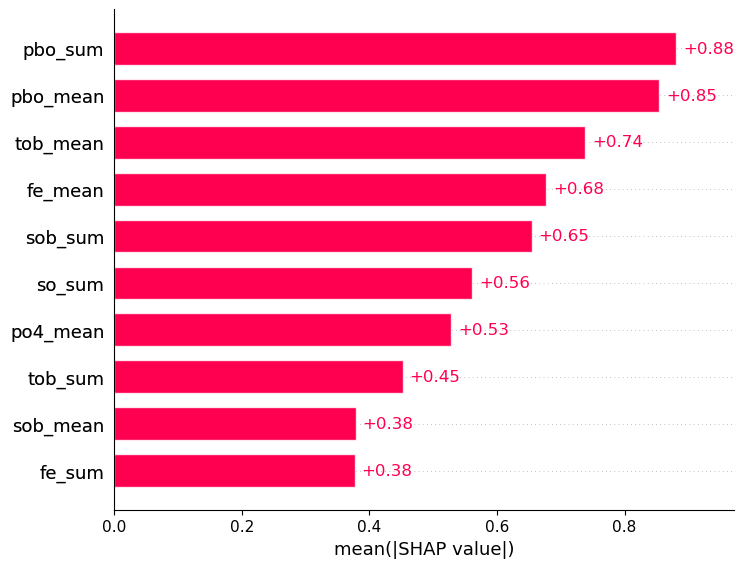

In [21]:
shap.plots.bar(shap_values)

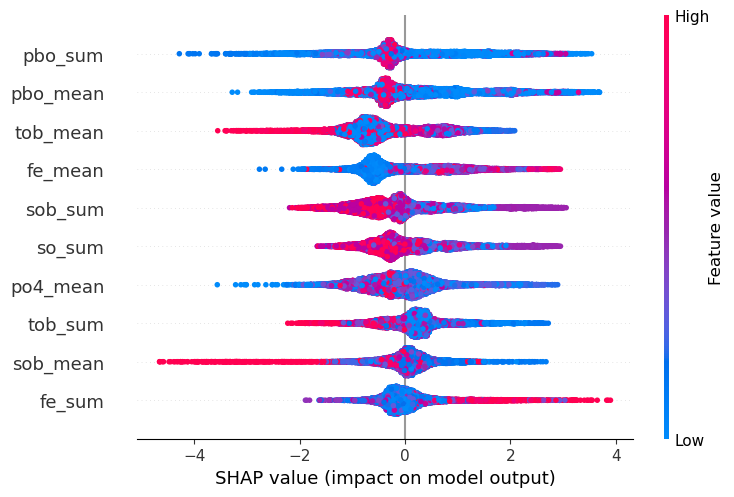

In [22]:
shap.plots.beeswarm(shap_values)

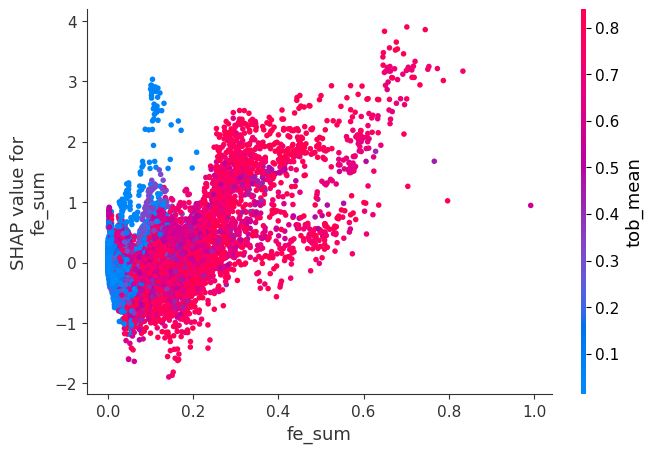

In [41]:
shap.dependence_plot("fe_sum", shap_values.values, shap_df)

## Reclassify

In [9]:
gpd_africa = gpd.read_file("../dataset/africa/shp/grid-sea-africa-zoned.shp")
gpd_australia = gpd.read_file("../dataset/australia/shp/grid-sea-australia-zoned.shp")

In [10]:
df_africa = pd.read_parquet("../dataset/combined/zonal/africa.parquet")
df_australia = pd.read_parquet("../dataset/combined/zonal/australia.parquet")

In [35]:
viscols = X_train.columns.tolist() + ["target", "ts", "zone_id"]
df_visualize = pd.concat([
    df_africa[df_africa["ts"].between("2023-05-01", "2023-05-30")][viscols].assign(country="africa"),
    df_australia[df_australia["ts"].between("2023-05-01", "2023-05-30")][viscols].assign(country="australia"),
], ignore_index=True)

df_visualize.head()

sob_mean     sob_sum   fe_mean    fe_sum      so_sum  po4_mean  \
0      35.026119  105.078362  0.002330  0.002330  105.905983  0.230662   
1      35.265999   35.265999  0.002189  0.004377   35.320118  0.240582   
2      35.243912  105.731735  0.002399  0.002399  105.698517  0.230044   
3      35.234768   70.469536  0.001953  0.001953   70.475334  0.236275   
4      35.151783  210.910690  0.001516  0.001516  211.169373  0.208846   
...          ...         ...       ...       ...         ...       ...   
33031  35.275578  282.204620  0.001068  0.001068  284.779785  0.252967   
33032  35.611771  320.505920  0.002013  0.002013  320.499390  0.223628   
33033  35.594292  213.565750  0.001194  0.001194  213.554733  0.243856   
33034  35.619514  284.956116  0.002372  0.002372  284.953674  0.224313   
33035  35.621418  213.728516  0.001650  0.001650  213.699142  0.231239   

         pbo_mean      pbo_sum   tob_mean     tob_sum  target         ts  \
0       45.163334   135.490005  12.226613   36.679840       0 2023-05-22   
1       35.651169    35.651169  16.405302   16.405302       1 2023-05-22   
2       32.090046    96.270142  15.963172   47.889515       0 2023-05-22   
3       29.342491    58.684982  15.350924   30.701847       1 2023-05-22   
4       27.001066   162.006393  15.107807   90.646843       1 2023-05-22   
...           ...          ...        ...         ...     ...        ...   
33031  324.118408  2592.947266  13.909698  111.277580       0 2023-05-27   
33032   76.230240   686.072144  16.513771  148.623932       0 2023-05-27   
33033   84.885696   509.314178  16.776623  100.659737       0 2023-05-27   
33034   65.535027   524.280212  16.247341  129.978729       0 2023-05-27   
33035   80.001411   480.008484  16.589600   99.537598       0 2023-05-27   

       zone_id    country  
0          126     africa  
1          135     africa  
2          169     africa  
3          178     africa  
4          188     africa  
...        ...        ...  
33031     4706  australia  
33032     4713  australia  
33033     4714  australia  
33034     4720  australia  
33035     4721  australia  

[33036 rows x 14 columns]

In [22]:
X_vis = scaler.transform(df_visualize.drop(columns=["target", "ts", "zone_id", "country"]))
y_vis = df_visualize["target"]
y_pred_vis = clf.predict(X_vis)

In [23]:
print("MCC:", np.round(matthews_corrcoef(y_vis, y_pred_vis), 4))
print("Accuracy:", np.round(accuracy_score(y_vis, y_pred_vis), 4))
print("Precision:", np.round(precision_score(y_vis, y_pred_vis), 4))
print("Recall:", np.round(recall_score(y_vis, y_pred_vis), 4))
print("F1:", np.round(f1_score(y_vis, y_pred_vis), 4))

print(classification_report(y_vis, y_pred_vis))

MCC: 0.7662
Accuracy: 0.9917
Precision: 0.592
Recall: 1.0
F1: 0.7437
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     32637
           1       0.59      1.00      0.74       399

    accuracy                           0.99     33036
   macro avg       0.80      1.00      0.87     33036
weighted avg       1.00      0.99      0.99     33036



In [32]:
def f_mcc(x):
    TP = x[1, 1]
    TN = x[0, 0]
    FP = x[0, 1]
    # FN = x[1, 0]
    FN = 0
    mcc = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return np.round(mcc, 4)

def f_f1(x):
    TP = x[1, 1]
    TN = x[0, 0]
    FP = x[0, 1]
    # FN = x[1, 0]
    FN = 0
    f1 = 2 * TP / (2 * TP + FP + FN)
    return np.round(f1, 4)

In [34]:
dv = df_visualize.copy()
dv["predicted"] = y_pred_vis
dv["ts_month"] = dv["ts"].dt.month

summary_whalemap = dv.pivot_table(index=["country", "ts_month"], columns=["target", "predicted"], aggfunc="size", fill_value=0)
summary_whalemap = summary_whalemap.reset_index()
summary_whalemap["mcc"] = summary_whalemap.apply(f_mcc, axis=1)
summary_whalemap["f1"] = summary_whalemap.apply(f_f1, axis=1)
summary_whalemap

target       country ts_month      0         1     mcc      f1
predicted                          0    1    1                
0             africa        5  21711  150  180  0.7360  0.7059
1          australia        5  10651  125  219  0.7932  0.7780

In [27]:
dv[["country", "target"]].value_counts().sort_index()

country    target
africa     0         21861
           1           180
australia  0         10776
           1           219
Name: count, dtype: int64

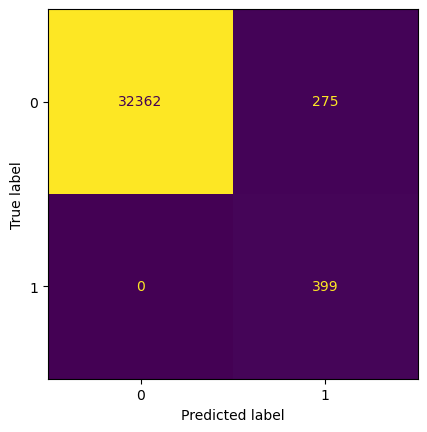

In [17]:
ConfusionMatrixDisplay.from_predictions(y_vis, y_pred_vis, colorbar=False)

### Visualize Maps

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [43]:
probas = clf.predict_proba(X_vis)
probas[probas == 0] = np.finfo(float).eps

In [44]:
probas

array([[8.57723577e-01, 1.42276423e-01],
       [8.13008130e-04, 9.99186992e-01],
       [7.43089431e-01, 2.56910569e-01],
       ...,
       [9.43089431e-01, 5.69105691e-02],
       [9.57723577e-01, 4.22764228e-02],
       [9.42276423e-01, 5.77235772e-02]])

In [52]:
df_pred = df_visualize[["zone_id", "country", "target"]].copy()
df_pred["proba"] = np.log(probas[:, 1])
df_pred["classified"] = clf.predict(X_vis)

df_pred = df_pred.groupby(["country", "zone_id"]).max().reset_index()
df_pred.head()

country  zone_id  target     proba  classified
0  africa      126       0 -1.949983           0
1  africa      135       1  0.000000           1
2  africa      169       0 -1.359027           0
3  africa      178       1  0.000000           1
4  africa      188       1  0.000000           1

In [46]:
df_pred[["country", "target"]].value_counts().sort_index()

country    target
africa     0         7287
           1           60
australia  0         3592
           1           73
Name: count, dtype: int64

In [47]:
df_pred[["country", "classified"]].value_counts().sort_index()

country    classified
africa     0             7243
           1              104
australia  0             3560
           1              105
Name: count, dtype: int64

In [48]:
def plot_map(df):
    fig, axes = plt.subplots(1, 2)
    axes[0].set_ylabel("Latitude")
    axes[0].set_xlabel("Longitude")
    df.plot(column="target", ax=axes[0])

    axes[1].set_ylabel("Latitude")
    axes[1].set_xlabel("Longitude")
    df.plot(column="classified", ax=axes[1])

    fig.tight_layout()
    plt.show()

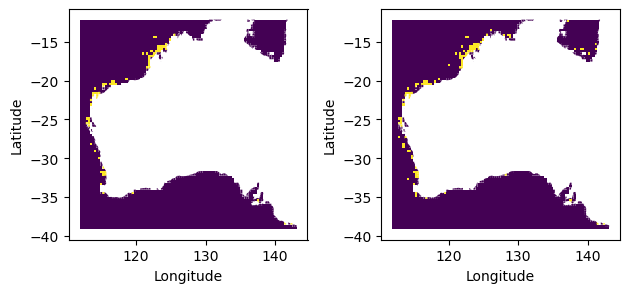

In [54]:
df_corr_aus = df_pred[df_pred["country"] == "australia"].copy()
gpd_res_aus = gpd_australia.merge(df_corr_aus, left_on="ZONE_ID", right_on="zone_id", how="left").drop(columns=["country", "zone_id"])
# gpd_res_aus.to_file("../dataset/reclassify/australia_classif_2023.shp")

plot_map(gpd_res_aus)

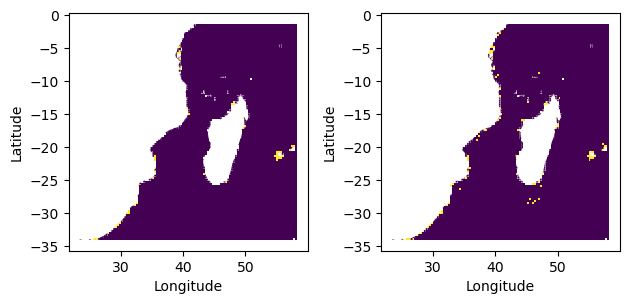

In [55]:
df_corr_africa = df_pred[df_pred["country"] == "africa"].copy()
gpd_res_africa = gpd_africa.merge(df_corr_africa, left_on="ZONE_ID", right_on="zone_id", how="left").drop(columns=["country", "zone_id"])
# gpd_res_africa.to_file("../dataset/reclassify/africa_classif_2023.shp")

plot_map(gpd_res_africa)

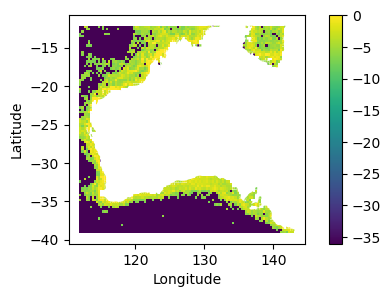

In [56]:
fig, ax = plt.subplots(figsize=(4, 4))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
gpd_res_aus.plot(column="proba", ax=ax, legend=True, cax=cax)
# gpd_res_africa.plot(column="proba", ax=ax, legend=True, cax=cax)


fig.tight_layout()
plt.show()